# 👷 Basic Setup 👷

In [19]:
# Install dependencies
#  Don't forget to switch the Runtime type to T4!
!pip install face-recognition
!pip install kaggle
!pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=a3d2073fdfd9acca8602cd27b2fcd712e4888eb3205ae98d0b93fed711b6f14c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [20]:
# Download Kaggle Dataset for Facial Expression Recognition
#  You will need your Kaggle username and password accessible under API Token here: https://www.kaggle.com/settings/account
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yusufauwalsani
Your Kaggle Key: ··········


100%|██████████| 121M/121M [00:00<00:00, 130MB/s]


In [21]:
# Import common libraries
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import face_recognition

In [22]:
# Webcam Utilities
# From https://stackoverflow.com/a/63590704 and https://colab.research.google.com/drive/1j7HTapCLx7BQUBp3USiQPZkA0zBKgLM0?usp=sharing
#  Code snippets by furas - adapted by David Melhart
#  Code licensed under CC-BY-SA 4.0 https://creativecommons.org/licenses/by-sa/4.0/
#
# based on: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
#

import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode


def init_camera():
  """Create objects and functions in HTML/JavaScript to access local web camera"""

  js = Javascript('''

    // global variables to use in both functions
    var div = null;
    var video = null;   // <video> to display stream from local webcam
    var stream = null;  // stream from local webcam
    var canvas = null;  // <canvas> for single frame from <video> and convert frame to JPG
    var img = null;     // <img> to display JPG after processing with `cv2`

    async function initCamera() {
      // place for video (and eventually buttons)
      div = document.createElement('div');
      div.style.display = 'flex';
      div.style.width = '100%';
      div.style.justifyContent = 'center';
      document.body.appendChild(div);

      // <video> to display video
      video = document.createElement('video');
      video.style.display = 'block';
      div.appendChild(video);

      // get webcam stream and assing to <video>
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;

      // start playing stream from webcam in <video>
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // <canvas> for frame from <video>
      canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      // <img> for image after processing with `cv2`
      img = document.createElement('img');
      img.width = video.videoWidth;
      img.height = video.videoHeight;
      div.appendChild(img);

      label = document.createElement('h1');
      label.style.textAlign = 'center';
      label.innerHTML = '...';
      document.body.appendChild(label);
    }

    async function takeImage(quality) {
      // draw frame from <video> on <canvas>
      canvas.getContext('2d').drawImage(video, 0, 0);

      // stop webcam stream
      //stream.getVideoTracks()[0].stop();

      // get data from <canvas> as JPG image decoded base64 and with header "data:image/jpg;base64,"
      return canvas.toDataURL('image/jpeg', quality);
      //return canvas.toDataURL('image/png', quality);
    }

    async function showImage(image) {
      // it needs string "data:image/jpg;base64,JPG-DATA-ENCODED-BASE64"
      // it will replace previous image in `<img src="">`
      img.src = image;
    }

    async function showLabel(text) {
      // it needs string
      // it will replace image label `<h1></h1>`
      label.innerHTML = text;
    }

  ''')

  display(js)
  eval_js('initCamera()')


def take_frame(quality=0.8):
  """Get frame from web camera"""

  data = eval_js('takeImage({})'.format(quality))  # run JavaScript code to get image (JPG as string base64) from <canvas>

  header, data = data.split(',')  # split header ("data:image/jpg;base64,") and base64 data (JPG)
  data = b64decode(data)  # decode base64
  data = np.frombuffer(data, dtype=np.uint8)  # create numpy array with JPG data

  img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)  # uncompress JPG data to array of pixels

  return img


def show_frame(img, quality=0.8):
  """Put frame as <img src="data:image/jpg;base64,...."> """

  ret, data = cv2.imencode('.jpg', img)  # compress array of pixels to JPG data

  data = b64encode(data)  # encode base64
  data = data.decode()  # convert bytes to string
  data = 'data:image/jpg;base64,' + data  # join header ("data:image/jpg;base64,") and base64 data (JPG)

  eval_js('showImage("{}")'.format(data))  # run JavaScript code to put image (JPG as string base64) in <img>
                                           # argument in `showImage` needs `" "`


def show_label(label):
  """Update image lavel"""
  eval_js('showLabel("{}")'.format(label))  # run JavaScript code to update image label in <h1>
                                            # argument in `showImage` needs `" "`


# 👇 The Tutorial Starts Here 👇

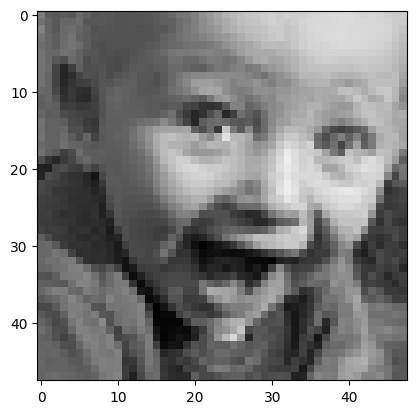

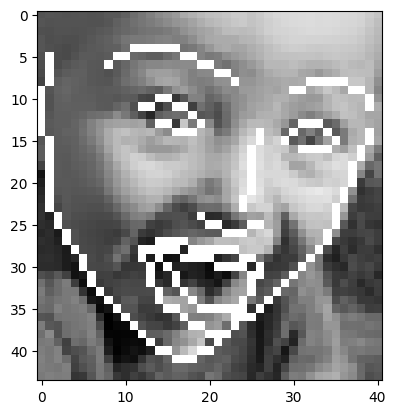

array([[[ 82,  82,  82],
        [ 85,  85,  85],
        [ 84,  84,  84],
        ...,
        [212, 212, 212],
        [204, 204, 204],
        [196, 196, 196]],

       [[ 85,  85,  85],
        [ 82,  82,  82],
        [ 83,  83,  83],
        ...,
        [211, 211, 211],
        [201, 201, 201],
        [190, 190, 190]],

       [[ 80,  80,  80],
        [ 79,  79,  79],
        [ 82,  82,  82],
        ...,
        [206, 206, 206],
        [196, 196, 196],
        [186, 186, 186]],

       ...,

       [[129, 129, 129],
        [120, 120, 120],
        [131, 131, 131],
        ...,
        [ 99,  99,  99],
        [ 97,  97,  97],
        [ 93,  93,  93]],

       [[126, 126, 126],
        [122, 122, 122],
        [119, 119, 119],
        ...,
        [105, 105, 105],
        [ 86,  86,  86],
        [ 90,  90,  90]],

       [[122, 122, 122],
        [128, 128, 128],
        [124, 124, 124],
        ...,
        [106, 106, 106],
        [ 78,  78,  78],
        [ 85,  85,  85]]

In [23]:
# TODO:
#  - Write facial recognition utiliy
#    - Face detection - isolate faces
#    - Visualization - facial landmark detection
#    - Feature extraction - calculate facial embeddings
#  - Make sure it works correctly on still images
#  - Write processing script for dataset
#  - Train an ML model to recognize emotions
#  - Update the diplay function in the webcam utilites to display the prediction

# facial recognition utiliy
def find_face(image, only_face=True, verbose=False):
  pixel_array = np.array(image)

  try:
    face_landmarks = face_recognition.face_landmarks(pixel_array)[0]

    pixel_landmarks = Image.fromarray(pixel_array)
    pil_im = ImageDraw.Draw(pixel_landmarks)
    for landmark in face_landmarks:
      pil_im.line(face_landmarks[landmark], width=1)

    if only_face:
      face_location = face_recognition.face_locations(pixel_array)[0]
      top = face_location[0]
      right = face_location[1]
      bottom = face_location[2]
      left = face_location[3]
      pixel_face = np .array(pixel_landmarks)[top:bottom, left:right]
      return pixel_face

    return np.array(pixel_landmarks)

  except Exception as err:
    if verbose:
      print(err)
    pass

image = Image.open("/content/face-expression-recognition-dataset/images/train/happy/1014.jpg")
image = image.convert("RGB")
plt.imshow(image)
plt.show()

landmarks = find_face(image, only_face=True)
plt.imshow(landmarks)
plt.show()


find_face(image)


In [30]:
# init_camera()
# run_display()
# run_display(verbose=True)

base_dir = "/content/face-expression-recognition-dataset/images/"

def get_set(dir="train", label_size=None, labels=None):
  X = []
  y = []

  for label in os.listdir(os.path.join(base_dir, dir)):
    _label_size = label_size
    if label is not None:
      if label in labels:
        pass
      else:
        continue

    for filename in os.listdir(os.path.join(base_dir, dir, label)):
      image = Image.open(os.path.join(base_dir, dir, label, filename))
      image = image.convert("RGB")
      pixel_array = np.array(image)
      # print(pixel_array)
      try:
        if _label_size is None or _label_size > 0:
          face_embedding = face_recognition.face_encodings(pixel_array)[0]
          X.append(face_embedding)
          y.append(label)
          if _label_size is not None:
            _label_size -= 1
      except Exception as err:
        # print(err)
        pass
  return X, y


In [31]:
X_train, y_train = get_set("train", 800, ["angry", "happy", "disgust", "surprise", "sad"])
X_test, y_test = get_set("validation", 200, ["angry", "happy", "disgust", "surprise", "sad"])

# print("angry train", sum([1 if x == "angry" else 0 for x in y_train]))
# print("happy train", sum([1 if x == "happy" else 0 for x in y_train]))
# print("neutral train", sum([1 if x == "neutral" else 0 for x in y_train]))

# print("angry test", sum([1 if x == "angry" else 0 for x in y_train]))
# print("happy test", sum([1 if x == "happy" else 0 for x in y_train]))
# print("neutral test", sum([1 if x == "neutral" else 0 for x in y_train]))

In [32]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", gamma=6)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print("Train Acc: ", np.round(svm_clf.score(X_train, y_train)*100, 2))
print("Test Acc: ", np.round(svm_clf.score(X_test, y_test)*100, 2))




Train Acc:  96.55
Test Acc:  63.89


In [33]:
import random
import time

# List of jokes
jokes = [
    "Why don't scientists trust atoms? Because they make up everything!",
    "Did you hear about the mathematician who's afraid of negative numbers? He will stop at nothing to avoid them!",
    "Why don't skeletons fight each other? They don't have the guts!",
    "I'm reading a book about anti-gravity. It's impossible to put down!",
    "Why did the scarecrow win an award? Because he was outstanding in his field!",
]


In [34]:
def run_display(quality=0.8, verbose=False):
  """
  Update the running diplay with captures
  Don't forget to call `init_camera` beforehand
  """
  while True:
      try:
          img = take_frame(quality)  # export next frame from the webcam feed


          face = find_face(img, only_face=True, verbose=True)

          face_embeddings = face_recognition.face_encodings(img)[0]
          label = svm_clf.predict(face_embeddings.reshape(1, -1))[0]

          show_frame(face, quality)  # it replace previous image

          #show_label(label) # it replaces the label in <h1> below the display

          # Check if the input string is equal to "angry"
          if label == "angry" or label == "sad" or label == "disgust":
            # Generate a random joke
            random_joke = random.choice(jokes)
            show_label(label)
            show_label(random_joke)
          elif label == "happy" or label == "surprise":
            show_label(label)
            show_label("Laughter is the best medicine!")

      except Exception as err:
        #if verbose:
          #print('Exception:', err)
        pass

In [ ]:
init_camera()
run_display()

list index out of range
